In [2]:
# Alle notwendigen Import werden Hier gemacht

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Methode zum Einlesen der Daten und Berechnen der Laufszeiten.

def read_and_compute_runtime(filename):
    df = pd.read_csv(filename, sep=r"\s+", header=None,
                     names=["id", "start", "pre_end", "solver_end"])

    time_format = "%d.%m.%Y-%H:%M:%S"
    df["start"] = pd.to_datetime(df["start"], format=time_format)
    df["solver_end"] = pd.to_datetime(df["solver_end"], format=time_format)
    df["runtime_s"] = (df["solver_end"] - df["start"]).dt.total_seconds()

    return df

# r1=read_and_compute_runtime("runtimes.mp80")
#print(r1)


In [4]:
#Methode read_and_compute_runtime aufrufen, Laufzeiten, Mittelwerte, Varianz , median und standardabweichungen  von Jede Prozessor berechnen
# und in einem DataFrame (~ Dictionary ) speichern 


files = {
    "Intel N95 (mp80)": "runtimes.mp80",
    "Intel N100": "runtimes.n100",
    "Raspberry Pi 5": "runtimes.pi5"
}

data = {name: read_and_compute_runtime(path) for name, path in files.items()}
print(data)

results=[]
for name, df in data.items():
    mean = df["runtime_s"].mean()
    median = df["runtime_s"].median()
    var = df["runtime_s"].var()
    std = df["runtime_s"].std()
    max=df["runtime_s"].max()
    min=df["runtime_s"].min()
    
    
    results.append({'Name': name,'Mean': mean,'Median': median,'Standardabweichung': std, 'MinZeit (in Sekunden)': min,'MaxZeit(in Sekunden': max})

# jetz als DataFrame umwandeln
mmvs_df = pd.DataFrame(results)

#print(mmvs_df)

{'Intel N95 (mp80)':         id               start              pre_end          solver_end  \
0        0 2024-05-03 17:11:29  03.05.2024-17:11:36 2024-05-03 17:11:58   
1        1 2024-05-03 17:11:58  03.05.2024-17:12:25 2024-05-03 17:13:03   
2        2 2024-05-03 17:13:03  03.05.2024-17:13:10 2024-05-03 17:13:27   
3        3 2024-05-03 17:13:27  03.05.2024-17:13:33 2024-05-03 17:13:53   
4        4 2024-05-03 17:13:53  03.05.2024-17:14:10 2024-05-03 17:14:35   
...    ...                 ...                  ...                 ...   
1995  1995 2024-05-05 01:41:54  05.05.2024-01:42:07 2024-05-05 01:42:17   
1996  1996 2024-05-05 01:42:17  05.05.2024-01:42:27 2024-05-05 01:42:48   
1997  1997 2024-05-05 01:42:48  05.05.2024-01:42:56 2024-05-05 01:43:36   
1998  1998 2024-05-05 01:43:36  05.05.2024-01:43:44 2024-05-05 01:44:26   
1999  1999 2024-05-05 01:44:26  05.05.2024-01:44:33 2024-05-05 01:44:44   

      runtime_s  
0          29.0  
1          65.0  
2          24.0  
3     

In [ ]:
#extrahiere die Laufnummern der Instanzen, denen Laufzeiten 0 Sekunden ist vom Intel N100
error=[]
df_N100=data["Intel N100"]
print(df_N100)

for _, row in df_N100.iterrows():
    if row["runtime_s"] == 0:
        error.append(row["id"])

print(len(error))

        id               start              pre_end          solver_end  \
0        0 2024-12-23 12:59:22  23.12.2024-12:59:22 2024-12-23 12:59:22   
1        1 2024-12-23 12:59:22  23.12.2024-12:59:22 2024-12-23 12:59:22   
2        2 2024-12-23 12:59:22  23.12.2024-12:59:22 2024-12-23 12:59:22   
3        3 2024-12-23 12:59:22  23.12.2024-12:59:22 2024-12-23 12:59:22   
4        4 2024-12-23 12:59:22  23.12.2024-12:59:22 2024-12-23 12:59:22   
...    ...                 ...                  ...                 ...   
3995  1995 2024-12-24 16:43:56  24.12.2024-16:44:08 2024-12-24 16:44:20   
3996  1996 2024-12-24 16:44:20  24.12.2024-16:44:31 2024-12-24 16:44:50   
3997  1997 2024-12-24 16:44:50  24.12.2024-16:44:56 2024-12-24 16:45:18   
3998  1998 2024-12-24 16:45:18  24.12.2024-16:45:24 2024-12-24 16:46:02   
3999  1999 2024-12-24 16:46:02  24.12.2024-16:46:09 2024-12-24 16:46:26   

      runtime_s  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4        

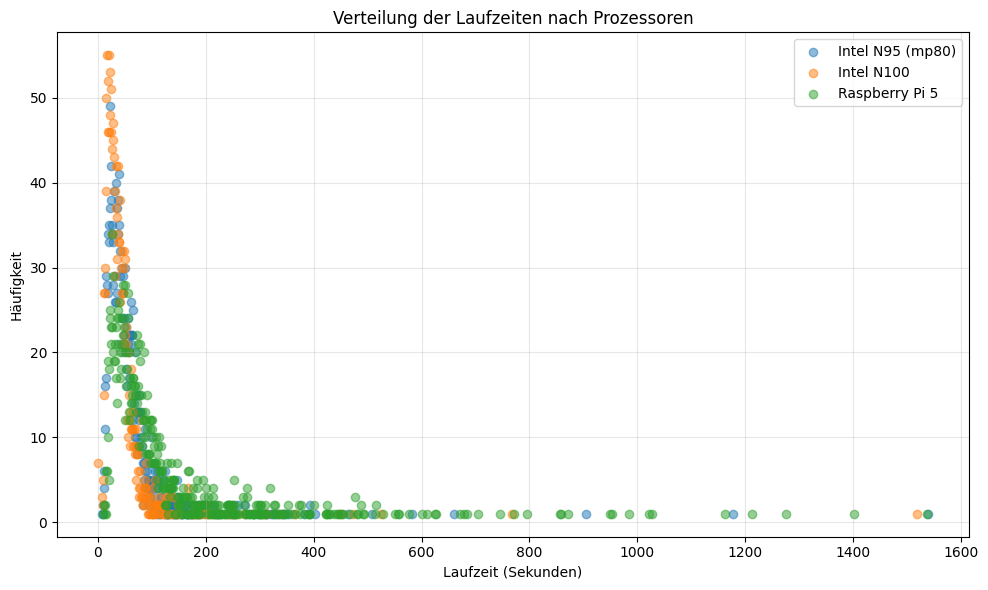

In [49]:
plt.ion()
plt.figure(figsize=(10, 6))

counts_dict = {}
for name, df in data.items():
    
    runtimes_rounded = df["runtime_s"] #.round(1)
    counts = runtimes_rounded.value_counts().sort_index()
    counts_dict[name]=counts
    counts = counts[(counts.index >= 0) & (counts.index <= 2000)]
    counts=counts[(counts.values>=0 )& (counts.values<=250)]
    plt.scatter(counts.index,counts.values , label=name,alpha=0.5)
    #plt.plot(counts.index, counts.values, label=name)
    
plt.xlabel("Laufzeit (Sekunden)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Laufzeiten nach Prozessoren")
#plt.xlim(-10, 600)
#plt.ylim(-10, 80)
plt.legend()
plt.legend()
plt.tight_layout()
plt.savefig("runtime_distribution111.png") 
plt.grid(True, alpha=0.3)
plt.show()

counts_df=pd.DataFrame(counts_dict); counts_df = counts_df.fillna(0) # Laufzeiten und deren Haufigken in einem DataFrame gespeichert.
#print(counts_df)